In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
finalized_reviews = pd.read_csv("finalized_reviews.csv")
finalized_reviews.head()

,Unnamed: 0,review_content,Sentiment
0,0,middle school teacher gifted literature value ...,1
1,1,lightning thief admirable kid fantasy,1
2,2,ok,-1
3,3,there resembling spark film,-1
4,4,truly film age darkly comic stuff mistress mis...,1


In [25]:
from sklearn.model_selection import train_test_split
X_data = finalized_reviews[['review_content']]
y_data = finalized_reviews['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size = 0.2, 
                                                    random_state=1, 
                                                    stratify = y_data)

print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)
print('Train/Valid/Test sizes:', y_train.shape[0], y_valid.shape[0], y_test.shape[0])

X_train.shape: (36596, 1)
y_train.shape: (36596,)
X_test.shape: (9150, 1)
y_test.shape: (9150,)
Train/Valid/Test sizes: 36596 7320 9150


In [26]:
# count vectorizer:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
# vectorize X_train and X_test
train_matrix = vec.fit_transform(X_train['review_content'].values.astype('U'))
test_matrix = vec.transform(X_test['review_content'].values.astype('U'))

In [27]:
X_train = train_matrix
X_test = test_matrix
y_train = y_train.astype('int')
y_test = y_test.astype('int')
# print dimensions
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36596, 32922)
(36596,)
(9150, 32922)
(9150,)


In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier
from mlxtend.evaluate import BootstrapOutOfBag

%matplotlib inline
import matplotlib.pyplot as plt

In [33]:
tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, y_train)
print(f"Train Accuracy: {tree.score(X_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {tree.score(X_test, y_test)*100:0.3f}%")

Train Accuracy: 99.978%
Test Accuracy: 75.366%


# GridSearchCV

In [31]:
# try KFold
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, 10, None],
               'criterion': ['gini', 'entropy']}]

tree = DecisionTreeClassifier(random_state=1)
gs = GridSearchCV(estimator=tree,
                  param_grid=param_grid,
                  scoring='accuracy',
                  refit=True,
                  n_jobs = None,
                  cv=inner_cv)
gs.fit(X_train, y_train)
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)
for i in range(len(gs.cv_results_['mean_test_score'])):
    print(gs.cv_results_['mean_test_score'][i], gs.cv_results_['params'][i]) 

Best Accuracy: 75.58%
Best Params: {'criterion': 'entropy', 'max_depth': None}
0.7174554620167055 {'criterion': 'gini', 'max_depth': 1}
0.7194775215540093 {'criterion': 'gini', 'max_depth': 2}
0.7232211613851316 {'criterion': 'gini', 'max_depth': 3}
0.7254345972278848 {'criterion': 'gini', 'max_depth': 4}
0.7284131126632885 {'criterion': 'gini', 'max_depth': 5}
0.7289049607450451 {'criterion': 'gini', 'max_depth': 6}
0.7352990754140176 {'criterion': 'gini', 'max_depth': 10}
0.7511748559208001 {'criterion': 'gini', 'max_depth': None}
0.7174554620167055 {'criterion': 'entropy', 'max_depth': 1}
0.7193135871277798 {'criterion': 'entropy', 'max_depth': 2}
0.7230299045545305 {'criterion': 'entropy', 'max_depth': 3}
0.7253253076103985 {'criterion': 'entropy', 'max_depth': 4}
0.7282765006414306 {'criterion': 'entropy', 'max_depth': 5}
0.7283584827889014 {'criterion': 'entropy', 'max_depth': 6}
0.7332496785379863 {'criterion': 'entropy', 'max_depth': 10}
0.7557653932141273 {'criterion': 'entrop

In [32]:
print('Best Params: %s' % gs.best_params_)
print('Train Accuracy: %.2f%%' % (gs.best_estimator_.score(X_train, y_train)*100))
print('Test Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Best Params: {'criterion': 'entropy', 'max_depth': None}
Test Accuracy: 99.98%
Test Accuracy: 75.67%


In [34]:
# manually input the parameters
tree = DecisionTreeClassifier(random_state=1, criterion = 'entropy', max_depth = None)
tree.fit(X_train, y_train)
print(f"Train Accuracy: {tree.score(X_train, y_train)*100:0.3f}%")
print(f"Test Accuracy: {tree.score(X_test, y_test)*100:0.3f}%")

Train Accuracy: 99.978%
Test Accuracy: 75.672%


# Plots

In [111]:
from tqdm import tqdm

In [112]:
tree = DecisionTreeClassifier(random_state=1, criterion = 'entropy', max_depth = None)

pred_train, pred_test = [], []

intervals = np.arange(500, X_train.shape[0] + 1, 1000)

for i in tqdm(intervals):
    tree.fit(X_train[:i], y_train[:i])
    p_train = tree.score(X_train[:i], y_train[:i])
    p_test = tree.score(X_test, y_test)
    pred_train.append(p_train)
    pred_test.append(p_test)

100%|██████████| 37/37 [02:27<00:00,  4.00s/it]


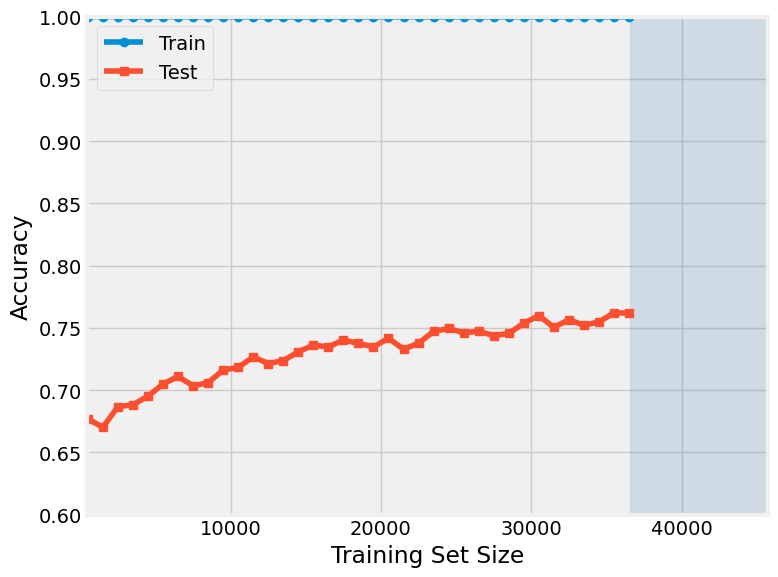

In [115]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=100)
with plt.style.context(('fivethirtyeight')):
    plt.plot(intervals, pred_train, marker='o', label='Train')
    plt.plot(intervals, pred_test, marker='s', label='Test')
    plt.legend(loc='best', numpoints=1)
    plt.xlim([430, X_train.shape[0] + X_test.shape[0]])
    plt.axvspan(X_train.shape[0], 
                X_train.shape[0] + X_test.shape[0], 
                alpha=0.2, 
                color='steelblue')
    plt.ylim([0.6, 1.0])
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    #plt.savefig('figures/model-eval-mnist_0.svg')

# Confidence Interval

## Train Confidence Interval

In [35]:
rng = np.random.RandomState(seed=1)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []

for i in range(200):
    
    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    test_idx = np.setdiff1d(idx, train_idx, assume_unique=False)
    
    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_test_X, boot_test_y = X_train[test_idx], y_train[test_idx]
    
    tree.fit(boot_train_X, boot_train_y)
    acc = tree.score(boot_test_X, boot_test_y)
    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
bootstrap_train_mean

0.7363577610647022

In [66]:
bootstrap_percentile_lower = np.percentile(bootstrap_train_accuracies, 2.5)
bootstrap_percentile_upper = np.percentile(bootstrap_train_accuracies, 97.5)

print(bootstrap_percentile_lower, bootstrap_percentile_upper)

0.7253845397414905 0.7470635796358093


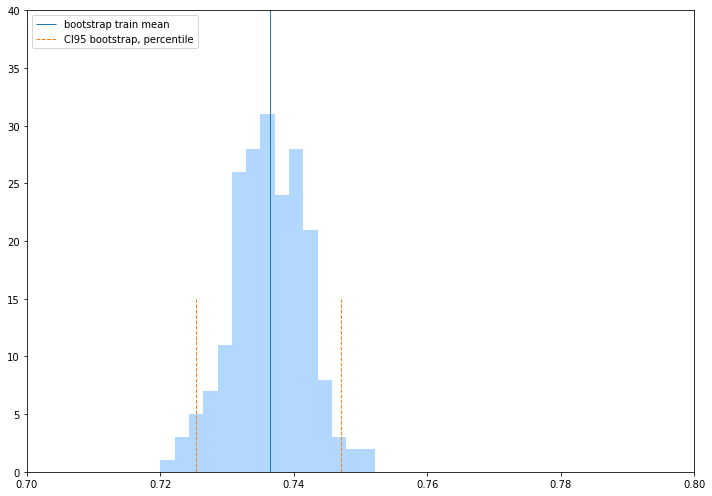

In [72]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.vlines(bootstrap_train_mean, [0], 80, lw=1, linestyle='-', label='bootstrap train mean')

ax.vlines(bootstrap_percentile_upper, [0], 15, lw=1, linestyle='dashed', 
          label='CI95 bootstrap, percentile', color='C1')
ax.vlines(bootstrap_percentile_lower, [0], 15, lw=1, linestyle='dashed', color='C1')

ax.hist(bootstrap_train_accuracies, bins=15,
        color='#0080ff', edgecolor="none", 
        alpha=0.3)
plt.legend(loc='upper left')

plt.xlim([0.7, 0.8])
plt.ylim([0, 40])
plt.tight_layout()
#plt.savefig('figures/bootstrap-histo-1.svg')

plt.show()

## Test Accuracy by Normal Approximation

In [76]:
tree.fit(X_train, y_train)
acc_test_na = tree.score(X_test, y_test)
ci_test_na = 1.96 * np.sqrt((acc_test_na*(1-acc_test_na)) / y_test.shape[0])

test_na_lower = acc_test_na-ci_test_na
test_na_upper = acc_test_na+ci_test_na

print(test_na_lower, test_na_upper)

0.7479297596644549 0.7655128632863649


# Bootstrap Methods

## OOB Bootstrap with Percentile Method

In [103]:
from mlxtend.evaluate import bootstrap_point632_score
bootstrap_scores = bootstrap_point632_score(tree, 
                                            X_train, y_train, 
                                            n_splits=200, 
                                            method='oob',
                                            random_seed=1)

bootstrap_oob_mean = np.mean(bootstrap_scores)
print('Mean Bootstrap score', bootstrap_oob_mean)
print('Score Std', np.std(bootstrap_scores))

bootstrap_oob_percentile_lower = np.percentile(bootstrap_scores, 2.5)
bootstrap_oob_percentile_upper = np.percentile(bootstrap_scores, 97.5)
print(bootstrap_oob_percentile_lower, bootstrap_oob_percentile_upper)

Mean Bootstrap score 0.7363577610647022
Score Std 0.005491419678305956
0.7253845397414905 0.7470635796358093


## .632 Bootstrap

In [101]:
bootstrap_scores = bootstrap_point632_score(tree, 
                                            X_train, y_train, 
                                            n_splits=200,
                                            random_seed=1)

bootstrap_632_mean = np.mean(bootstrap_scores)
print('Mean Bootstrap score', bootstrap_632_mean)
print('Score Std', np.std(bootstrap_scores))

bootstrap_632_percentile_lower = np.percentile(bootstrap_scores, 2.5)
bootstrap_632_percentile_upper = np.percentile(bootstrap_scores, 97.5)
print(bootstrap_632_percentile_lower, bootstrap_632_percentile_upper)

Mean Bootstrap score 0.7976308910897331
Score Std 0.0042312576782171755
0.789428590380148 0.8059752676943522


# Plot the Confidence Intervals

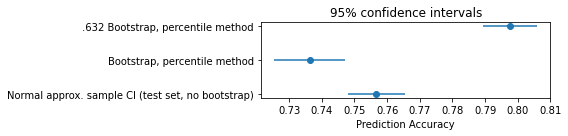

In [104]:
labels = [
    "Normal approx. sample CI (test set, no bootstrap)",
    "Bootstrap, percentile method",
    ".632 Bootstrap, percentile method"
]

mean = [
    acc_test_na,
    bootstrap_oob_mean,
    bootstrap_632_mean
]

lower_error = [
    test_na_lower,
    bootstrap_oob_percentile_lower,
    bootstrap_632_percentile_lower
]

upper_error = [
    test_na_upper,
    bootstrap_oob_percentile_upper,
    bootstrap_632_percentile_upper
]


asymmetric_error = [np.array(mean) - np.array(lower_error), 
                    np.array(upper_error) - np.array(mean)]


fig, ax = plt.subplots(figsize=(8, 2))
ax.errorbar(mean, np.arange(len(mean)), xerr=asymmetric_error, fmt='o')
#ax.set_xlim([0.86, 1.0])
ax.set_yticks(np.arange(len(mean)))
ax.set_yticklabels(labels)
ax.set_xlabel('Prediction Accuracy')
ax.set_title('95% confidence intervals')
plt.tight_layout()
plt.savefig('CI_mnist.pdf')
plt.show()

# Confusion Matrix

21.2 µs ± 231 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
8.07 s ± 76.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
[[1552 1068]
 [1158 5372]]


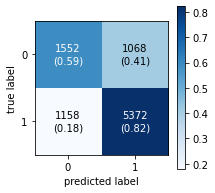

In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

%timeit pipe = make_pipeline(StandardScaler(with_mean=False), DecisionTreeClassifier(random_state=1, criterion = 'entropy', max_depth = None))

%timeit pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
confmat = confusion_matrix(y_test, y_pred)
print(confmat)

fig, ax = plot_confusion_matrix(conf_mat=confmat,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                figsize=(3, 3))
plt.show()
